In [ ]:
'''
전이학습을 통한 classificaion  문제 해결
전이학습은 기존에 훈련된 모델의 가중치를 가져와 모델에 적용시키는 학습 방법
'''

In [22]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np

from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

In [23]:
#가중치 초기화를 무작위로 한 후 가중치를 순전파, 역전파를 통해 update를 하지만 이 전이학습의 경우는 기준에 미리 학습되어 있는
#신경망을 통해 초기화, 초기화된 가중치는 마지막에 연결되어 있는 전연결 부분을 제외하고 고정이 되고 마지막 전연결 부분은
#무작위의 가중치를 갖는 새로운 계층으로 대체되어 이 계층만 학습되게 한다

In [24]:
#data argumentation, normalization(데이터 증가, 일반화)
data_transforms = {'train' : transforms.Compose([transforms.RandomResizedCrop(224), transforms.RandomHorizontalFlip(),
                                                transforms.ToTensor(), transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])]),
                  'val' : transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224),
                                                transforms.ToTensor(), transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])]),
                  }

#데이터를 불러오는 경로 설정
data_dir='./hymenoptera_data'
image_datasets = {x:datasets.ImageFolder(os.path.join(data_dir,x),data_transforms[x]) for x in ['train', 'val']}

#데이터로더를 불러오는 설정
dataloaders = {x:torch.utils.data.DataLoader(image_datasets[x],batch_size=4,shuffle=True,num_workers=0) for x in ['train', 'val']}
dataset_sizes = {x:len(image_datasets[x]) for x in ['train', 'val']}
class_names =  image_datasets['train'].classes

#CUDA(GPU가속화)사용이 가능하게 만드는 설정
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


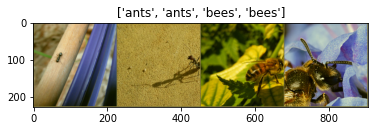

In [25]:
#사용하게될 데이터 시각화
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485,0.456,0.225])
    std = np.array([0.229,0.224,0.225])
    inp = std * inp + mean
    inp = np.clip(inp,0,1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
#학습 데이터의 배치를 얻는 과정
inputs, classes = next(iter(dataloaders['train']))

#배치로부터 격자 형태의 grid를 만드는 과정
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [26]:
#모델 학습

def train_model(model, criterion, optimizer, scheduler, num_epochs = 100):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0  #float 형식
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-' * 10)
        
        for phase in ['train', 'val']:   #phase에 따라 실행방법이 변경되게 되는데 phase가 train이면 train을
            if phase == 'train':
                model.train()
            else:    #train이 아닐경우 (val) val으로 실행(validation)
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                #순전파 과정
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _,preds = torch.max(outputs,1)
                    loss = criterion(outputs, labels)
                    
                    #학습 단계인 경우는 역전파+최적화 과정을 거치게됨
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                
                if phase == 'train':
                    scheduler.step()
                    
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                
                print('{} Loss: {:.4f} ACC: {:.4f}'.format(phase, epoch_loss, epoch_acc))
                
                if phase == 'val' and epoch_acc>best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    
                print()
                
            time_elapsed = time.time()-since
            print('Training complete in {:.0f}s'.format(time_elapsed//60, time_elapsed%60))
            print('Best val Acc: {:4f}'.format(best_acc))
            
            model.load_state_dict(best_model_wts)
            return model

In [27]:
#이미지에 대한 예측값을 보여주는 함수
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _,preds = torch.max(outputs,1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2,2,images_so_far)
                ax.axis('off')
                ax.set_title('predicted:{}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
            model.train(mode=was_training)

In [28]:
#신경망 미세조정(fine-tune)
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs,2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

#매개변수들이 최적화가 잘 되었는지 살펴보기
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

#에폭이 7 증가할때마다 학습률 0.1씩 감소시킴
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [29]:
#학습 진행 및 평가
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs = 100)

Epoch 0/99
----------
train Loss: 0.0148 ACC: 0.0082

train Loss: 0.0320 ACC: 0.0123

train Loss: 0.0422 ACC: 0.0205

train Loss: 0.0541 ACC: 0.0287

train Loss: 0.0655 ACC: 0.0369

train Loss: 0.0792 ACC: 0.0451

train Loss: 0.0924 ACC: 0.0533

train Loss: 0.1066 ACC: 0.0574

train Loss: 0.1168 ACC: 0.0656

train Loss: 0.1238 ACC: 0.0820

train Loss: 0.1312 ACC: 0.0984

train Loss: 0.1388 ACC: 0.1148

train Loss: 0.1472 ACC: 0.1230

train Loss: 0.1555 ACC: 0.1393

train Loss: 0.1685 ACC: 0.1475

train Loss: 0.1827 ACC: 0.1516

train Loss: 0.1921 ACC: 0.1598

train Loss: 0.2043 ACC: 0.1680

train Loss: 0.2167 ACC: 0.1803

train Loss: 0.2249 ACC: 0.1967

train Loss: 0.2373 ACC: 0.2049

train Loss: 0.2450 ACC: 0.2213

train Loss: 0.2553 ACC: 0.2295

train Loss: 0.2673 ACC: 0.2377

train Loss: 0.2793 ACC: 0.2459

train Loss: 0.2866 ACC: 0.2623

train Loss: 0.2950 ACC: 0.2787

train Loss: 0.3066 ACC: 0.2828

train Loss: 0.3191 ACC: 0.2910

train Loss: 0.3294 ACC: 0.3033

train Loss: 0.3352

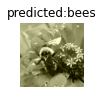

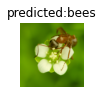

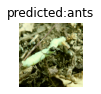

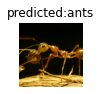

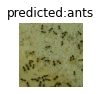

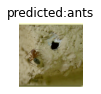

In [30]:
visualize_model(model_ft)    #예측한 결과를 보여줌

In [31]:
#전연결이 되지 않은 부분(마지막 부분)을 제외한 컨벌루션 레이어를 고정시키기 위한 코드
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
    
num_frts = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs,2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [32]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=100)

Epoch 0/99
----------
train Loss: 0.0104 ACC: 0.0123

train Loss: 0.0228 ACC: 0.0164

train Loss: 0.0341 ACC: 0.0246

train Loss: 0.0507 ACC: 0.0246

train Loss: 0.0653 ACC: 0.0287

train Loss: 0.0773 ACC: 0.0328

train Loss: 0.0915 ACC: 0.0369

train Loss: 0.1034 ACC: 0.0451

train Loss: 0.1151 ACC: 0.0533

train Loss: 0.1246 ACC: 0.0656

train Loss: 0.1370 ACC: 0.0697

train Loss: 0.1495 ACC: 0.0738

train Loss: 0.1638 ACC: 0.0738

train Loss: 0.1797 ACC: 0.0738

train Loss: 0.1910 ACC: 0.0820

train Loss: 0.2039 ACC: 0.0861

train Loss: 0.2161 ACC: 0.0943

train Loss: 0.2253 ACC: 0.1066

train Loss: 0.2366 ACC: 0.1148

train Loss: 0.2473 ACC: 0.1230

train Loss: 0.2608 ACC: 0.1311

train Loss: 0.2750 ACC: 0.1311

train Loss: 0.2881 ACC: 0.1352

train Loss: 0.3010 ACC: 0.1393

train Loss: 0.3135 ACC: 0.1475

train Loss: 0.3239 ACC: 0.1557

train Loss: 0.3330 ACC: 0.1680

train Loss: 0.3451 ACC: 0.1721

train Loss: 0.3591 ACC: 0.1762

train Loss: 0.3674 ACC: 0.1885

train Loss: 0.3772

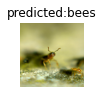

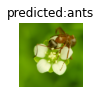

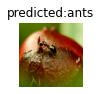

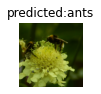

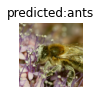

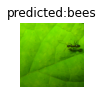

In [33]:
visualize_model(model_conv)

plt.ioff()
plt.show()
